# WatChMaL: MC Dropout Experiments
### Iñaki Erregue Álvarez-Buhilla

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from dictances import bhattacharyya
from sklearn.metrics import *
from utils.utils import *

# 1 - Dropout in Training 

Normal, FC, All, for different dropout rates

In [3]:
base_path = './data/dropout/'

labels = np.load(base_path+'/labels.npy')
test_idxs = np.load(base_path+'/indices.npy')
split_idxs = np.load(base_path+'/IWCD_mPMT_Short_2_class_idxs_xps.npz')

subfolders = [os.path.basename(os.path.normpath(f.path)) for f in os.scandir(base_path) if f.is_dir()]

In [4]:
len(subfolders)

64

In [5]:
data_splitting(split_idxs)

Total num. of events:  2950284
Events for testing: 10.004
Events for validation: 2.399
Events for training: 87.596


In [6]:
results = []
for mode in subfolders:
    results.append(basic_metrics(base_path, labels,mode))

In [7]:
pd.set_option("display.precision", 4)
df = pd.DataFrame(results)

df['total_score'] = df.acc+df.f1+df.auc-df.log_loss

df[['fc_dropout', 'bb_dropout', "learning_rate"]] = df.apply(lambda x: get_dropout_rates(x['model']), axis=1, result_type="expand")

df.sort_values(by='auc', inplace=True, ascending=False)
df = df[['fc_dropout', 'bb_dropout','learning_rate','log_loss', 'acc', 'f1', 'auc']].reset_index(drop=True)

df.head(10)


,fc_dropout,bb_dropout,learning_rate,log_loss,acc,f1,auc
0,0.1,0.00,0.0005,0.5904,0.6836,0.6689,0.7505
1,0.0,0.00,0.0003,0.5919,0.6828,0.6784,0.7493
2,0.1,0.00,0.0003,0.5945,0.6797,0.6871,0.7488
3,0.0,0.05,0.0005,0.5935,0.6807,0.6755,0.7464
4,0.0,0.00,0.0005,0.5941,0.6800,0.6735,0.7463
5,0.2,0.00,0.0005,0.5951,0.6780,0.6479,0.7460
6,0.3,0.00,0.0003,0.5940,0.6796,0.6655,0.7457
7,0.2,0.00,0.0003,0.5961,0.6783,0.6728,0.7433
8,0.1,0.05,0.0005,0.5975,0.6767,0.6622,0.7430
9,0.0,0.10,0.0005,0.5970,0.6771,0.6749,0.7425


In [8]:
df.sort_values(by='log_loss', inplace=False, ascending=True)

,fc_dropout,bb_dropout,learning_rate,log_loss,acc,f1,auc
0,0.1,0.00,0.0005,0.5904,0.6836,0.6689,0.7505
1,0.0,0.00,0.0003,0.5919,0.6828,0.6784,0.7493
3,0.0,0.05,0.0005,0.5935,0.6807,0.6755,0.7464
6,0.3,0.00,0.0003,0.5940,0.6796,0.6655,0.7457
4,0.0,0.00,0.0005,0.5941,0.6800,0.6735,0.7463
...,...,...,...,...,...,...,...
59,0.0,0.10,5.0000,0.6509,0.6134,0.6009,0.6605
62,0.2,0.10,5.0000,0.6534,0.6104,0.5851,0.6570
61,0.3,0.10,5.0000,0.6540,0.6102,0.6143,0.6571
60,0.2,0.15,5.0000,0.6547,0.6119,0.5973,0.6580


In [9]:
df_groupped = df.groupby(['fc_dropout','bb_dropout', 'learning_rate']).mean()
df_groupped.sort_values(by='auc', inplace=True, ascending=False)
df_groupped['auc_std'] = df.groupby(['fc_dropout','bb_dropout','learning_rate'])['auc'].std()
df_groupped['xps'] = df.groupby(['fc_dropout','bb_dropout', 'learning_rate'])['auc'].count()
df_groupped = pd.DataFrame(df_groupped.to_records())
len(df_groupped)

64

In [10]:
plt.rcParams.update({'font.size': 13})

In [11]:
def heatmap_plot(metric):
    
    if metric == 'auc':
        cmap = 'mako_r'
        vmin = 0.635
        vmax = 0.75
        title = 'AUC'
        
    
    elif metric == 'acc':
        cmap = 'rocket_r'
        vmin = 0.595
        vmax = 0.685
        title = 'Accuracy'
        
    elif metric == 'log_loss':
        cmap = 'cividis'#sns.cubehelix_palette(dark=1, light=0, as_cmap=True)
        vmin = 0.595
        vmax = 0.665
        title = 'Loss'


    fig, axes = plt.subplots(ncols=2, nrows=2, gridspec_kw={'width_ratios': [4, 5]}, figsize=(10,10))

    sns.heatmap(pd.pivot_table(df_groupped[df_groupped['learning_rate']==5], values=metric, columns=['fc_dropout'], index=['bb_dropout']).sort_index(ascending=False), 
                annot=True, cmap=cmap, vmin=vmin, vmax=vmax, square=True, cbar=None, ax=axes[0,0], fmt='.3g')
    axes[0,0].set_title(title + r' ($lr=5e-5$)')
    axes[0,0].set_xlabel(r'$p_w$')
    axes[0,0].set_ylabel(r'$p_c$')


    sns.heatmap(pd.pivot_table(df_groupped[df_groupped['learning_rate']==0.0001], values=metric, columns=['fc_dropout'], index=['bb_dropout']).sort_index(ascending=False), 
                annot=True, cmap=cmap, vmin=vmin, vmax=vmax, square=True, ax=axes[0,1], fmt='.3g')
    axes[0,1].set_title(title + r' ($lr=1e-4$)')
    axes[0,1].set_xlabel(r'$p_w$')
    axes[0,1].set_ylabel(r'$p_c$')

    sns.heatmap(pd.pivot_table(df_groupped[df_groupped['learning_rate']==3e-4], values=metric, columns=['fc_dropout'], index=['bb_dropout']).sort_index(ascending=False), 
                annot=True, cmap=cmap, vmin=vmin, vmax=vmax, square=True, cbar=None, ax=axes[1,0], fmt='.3g')
    axes[1,0].set_title(title + r' ($lr=3e-4$)')
    axes[1,0].set_xlabel(r'$p_w$')
    axes[1,0].set_ylabel(r'$p_c$')

    sns.heatmap(pd.pivot_table(df_groupped[df_groupped['learning_rate']==0.0005], values=metric, columns=['fc_dropout'], index=['bb_dropout']).sort_index(ascending=False), 
                annot=True, cmap=cmap, vmin=vmin, vmax=vmax, square=True, ax=axes[1,1], fmt='.3g')
    axes[1,1].set_title(title + r' ($lr=5e-4$)')
    axes[1,1].set_xlabel(r'$p_w$')
    axes[1,1].set_ylabel(r'$p_c$')

    plt.savefig(metric + 'dropouts.png', dpi=300, bbox_inches = "tight")
    plt.show()

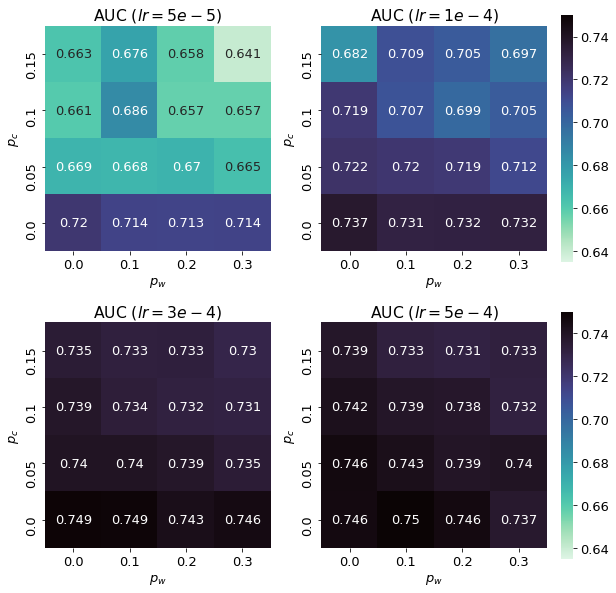

In [12]:
heatmap_plot('auc')

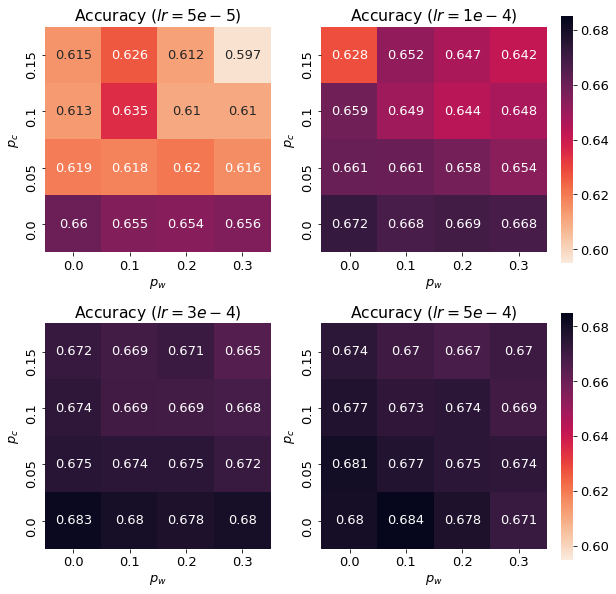

In [13]:
heatmap_plot('acc')

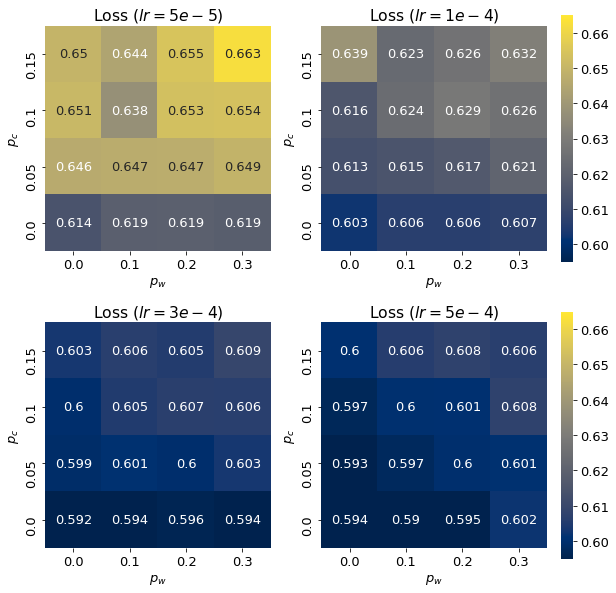

In [14]:
heatmap_plot('log_loss')

Found training logs:  ['./data/dropout/35/log_train_0.csv']


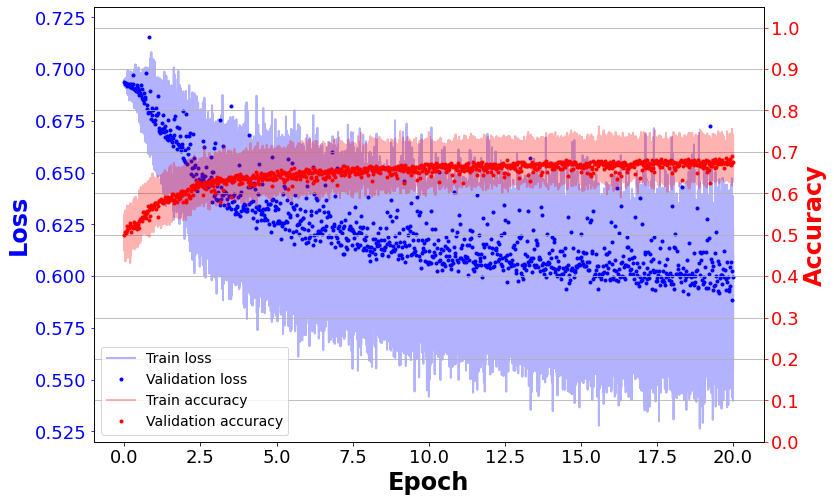

In [15]:
disp_learn_hist(base_path+'35', losslims=(0.52, 0.73))

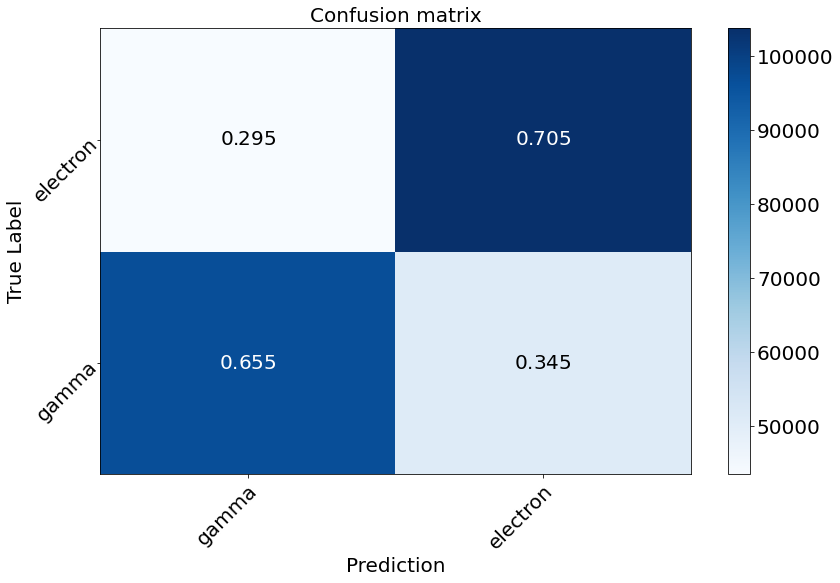

In [16]:
pred = np.load(base_path+'/35/predictions.npy')
plot_cm(labels,pred,np.array(['gamma','electron']))

# 2 - MC Dropout


## 2.1 - Model selection (Validation)

In [8]:
base_path = './data/mcd/results/'

labels = np.load(base_path+'/labels.npy')
test_idxs = np.load(base_path+'/indices.npy')
split_idxs = np.load(base_path+'/IWCD_mPMT_Short_2_class_idxs_xps.npz')

subfolders = [os.path.basename(os.path.normpath(f.path)) for f in os.scandir(base_path) if f.is_dir()]

In [9]:
len(subfolders)

27

In [10]:
data_splitting(split_idxs)

Total num. of events:  2950284
Events for testing: 10.004
Events for validation: 2.399
Events for training: 87.596


In [11]:
results = []
for mode in subfolders:
    results.append(basic_metrics(base_path, labels, mode+'/outputs'))

In [12]:
pd.set_option("display.precision", 4)
df = pd.DataFrame(results)

df['total_score'] = df.acc+df.f1+df.auc-df.log_loss

df['folder'] = df['model'].str.extract('(\d+)') 

df[['fc_dropout', 'bb_dropout', 'model']] = df.apply(lambda x: get_dropout_rates(x['folder'], base_path=base_path, model=True), axis=1, result_type="expand")



df.sort_values(by='auc', inplace=True, ascending=False)
df = df[['folder', 'model', 'fc_dropout', 'bb_dropout','log_loss', 'acc', 'f1', 'auc']].reset_index(drop=True)

df.head(10)

,folder,model,fc_dropout,bb_dropout,log_loss,acc,f1,auc
0,9,2.0,0.0,0.00,0.5892,0.6846,0.6800,0.7524
1,18,3.0,0.0,0.00,0.5891,0.6846,0.6788,0.7522
2,24,3.0,0.2,0.00,0.5892,0.6846,0.6785,0.7522
3,21,3.0,0.1,0.00,0.5882,0.6848,0.6786,0.7521
4,12,2.0,0.1,0.00,0.5895,0.6843,0.6792,0.7517
5,15,2.0,0.2,0.00,0.5939,0.6838,0.6779,0.7495
6,1,1.0,0.0,0.05,0.5921,0.6827,0.6691,0.7490
7,4,1.0,0.1,0.05,0.5917,0.6824,0.6660,0.7490
8,7,1.0,0.2,0.05,0.5922,0.6825,0.6640,0.7489
9,5,1.0,0.1,0.10,0.5943,0.6795,0.6528,0.7480


In [13]:
def b_distance_calculator(folder, base_path):

    uncertainties = np.load(base_path+folder+'/outputs/uncertainties.npy')

    predictions = np.expand_dims(np.load(base_path+folder+'/outputs/predictions.npy'), axis=1)
    probs = np.expand_dims(np.load(base_path+folder+'/outputs/softmax.npy')[:,1], axis=1)

    uncertainties = np.concatenate((uncertainties,probs,predictions,np.expand_dims(labels, axis=1)),axis=1)

    uncertainties_df = pd.DataFrame(uncertainties, columns=['total_variance', 'entropy', 'mutual_info', 'margin_confidence', 'variation_ratio', 'probs', 'pred', 'gt'])

    uncertainties_df['pred'] = uncertainties_df['pred'].astype(int)
    uncertainties_df['gt'] = uncertainties_df['gt'].astype(int)

    uncertainties_df['entropy'] = uncertainties_df['entropy']/np.log(2)

    uncertainties_df['correct_pred'] = np.where(uncertainties_df['pred'] == uncertainties_df['gt'], 1, 0)


    uncertainty_measures = ['total_variance', 'entropy', 'mutual_info', 'margin_confidence', 'variation_ratio']
    distances = []

    for measure in uncertainty_measures:

        correct = uncertainties_df[uncertainties_df['correct_pred'] == 1][measure]
        incorrect = uncertainties_df[uncertainties_df['correct_pred'] == 0][measure]
        correct_pmf = correct.value_counts(normalize=True)
        incorrect_pmf = incorrect.value_counts(normalize=True)

        distances.append(bhattacharyya_d(correct_pmf.reset_index(drop=True).to_dict(),incorrect_pmf.reset_index(drop=True).to_dict()))
        
    return distances

In [14]:
df[['d_tvar', 'd_h', 'd_i', 'd_m', 'd_vr']] = df.apply(lambda x: b_distance_calculator(x['folder'], base_path=base_path), axis=1, result_type="expand")

In [15]:
df_groupped = df.groupby(['fc_dropout','bb_dropout', 'model']).mean()
df_groupped = pd.DataFrame(df_groupped.to_records())
len(df_groupped)

27

In [16]:
df_groupped

,fc_dropout,bb_dropout,model,log_loss,acc,f1,auc,d_tvar,d_h,d_i,d_m,d_vr
0,0.0,0.00,1.0,0.5925,0.6809,0.6781,0.7475,0.0000,0.3721,0.0081,0.3741,0.0000
1,0.0,0.00,2.0,0.5892,0.6846,0.6800,0.7524,0.0000,0.3834,0.0082,0.3856,0.0000
2,0.0,0.00,3.0,0.5891,0.6846,0.6788,0.7522,0.0000,0.3822,0.0084,0.3853,0.0000
3,0.0,0.05,1.0,0.5921,0.6827,0.6691,0.7490,0.3824,0.3778,0.2957,0.3824,0.0186
4,0.0,0.05,2.0,0.6883,0.5236,0.1167,0.6472,0.0471,0.0559,0.0470,0.0471,0.0144
5,0.0,0.05,3.0,0.6594,0.6116,0.5252,0.6765,0.2253,0.2147,0.2227,0.2257,0.0183
6,0.0,0.10,1.0,0.5947,0.6798,0.6555,0.7479,0.3757,0.3726,0.3313,0.3757,0.0229
7,0.0,0.10,2.0,0.7474,0.5009,0.0011,0.5692,0.0022,0.0028,0.0019,0.0022,0.0011
8,0.0,0.10,3.0,0.6841,0.5342,0.2696,0.6076,0.0682,0.0731,0.0670,0.0682,0.0100
9,0.1,0.00,1.0,0.5926,0.6812,0.6752,0.7474,0.3786,0.3736,0.2564,0.3785,0.0122


In [17]:
df_groupped['d_tvar'].max()

0.3867924355456546

In [18]:
df_groupped['d_h'].max()

0.38409242391212706

In [19]:
df_groupped['d_i'].max()

0.3776370322781986

In [20]:
df_groupped['d_m'].max()

0.38697947586858916

In [21]:
df_groupped['d_vr'].max()

0.02382552413647507

In [46]:
plt.rcParams.update({'font.size': 18})

In [47]:
def heatmap_plot(metric):
    
    if metric == 'auc':
        cmap = 'mako_r'#'nipy_spectral_r'#'mako_r'
        vmin = 0.562
        vmax = 0.753
        title = 'AUC'
        
    
    elif metric == 'acc':
        cmap = 'rocket_r'
        vmin = 0.49
        vmax = 0.685
        title = 'Accuracy'
        
    elif metric == 'log_loss':
        cmap = 'cividis'
        vmin = 0.589
        vmax = 0.75
        title = 'Loss'
        
    elif metric == 'd_m':
        cmap = "YlGn"
        vmin = -0.01
        vmax = 0.39
        title = r'Margin $D_B$'
        
    elif metric == 'd_tvar':
        cmap = 'YlOrRd'
        vmin = -0.01
        vmax = 0.39
        title = r'Var $D_B$'


    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18,6), gridspec_kw={'width_ratios': [4, 4, 5]})

    sns.heatmap(pd.pivot_table(df_groupped[df_groupped['model']==3], values=metric, columns=['fc_dropout'], index=['bb_dropout']).sort_index(ascending=False), 
                annot=True, cmap=cmap, vmin=vmin, vmax=vmax, square=True, ax=axes[1], fmt='.3g', cbar=None)
    axes[1].set_title(title + r' (weight dropouts)')
    axes[1].set_xlabel(r'$p_w$')
    axes[1].set_ylabel(r'$p_c$')
    
    
    sns.heatmap(pd.pivot_table(df_groupped[df_groupped['model']==1], values=metric, columns=['fc_dropout'], index=['bb_dropout']).sort_index(ascending=False), 
                annot=True, cmap=cmap, vmin=vmin, vmax=vmax, square=True, ax=axes[2], fmt='.3g')
    axes[2].set_title(title + r' (both dropouts)')
    axes[2].set_xlabel(r'$p_w$')
    axes[2].set_ylabel(r'$p_c$')


    sns.heatmap(pd.pivot_table(df_groupped[df_groupped['model']==2], values=metric, columns=['fc_dropout'], index=['bb_dropout']).sort_index(ascending=False), 
                annot=True, cmap=cmap, vmin=vmin, vmax=vmax, square=True, ax=axes[0], fmt='.3g', cbar=None)
    axes[0].set_title(title + r' (no dropout)')
    axes[0].set_xlabel(r'$p_w$')
    axes[0].set_ylabel(r'$p_c$')

    plt.savefig(metric + '_val_dropouts.png', dpi=300, bbox_inches = "tight")
    plt.show()

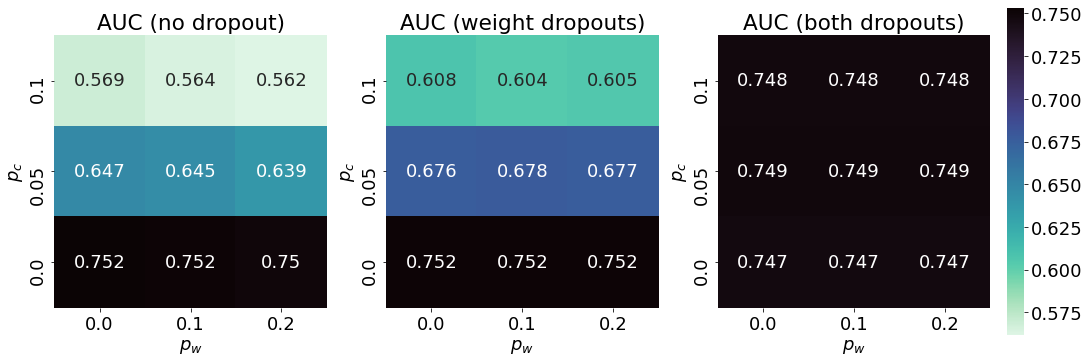

In [48]:
heatmap_plot('auc')

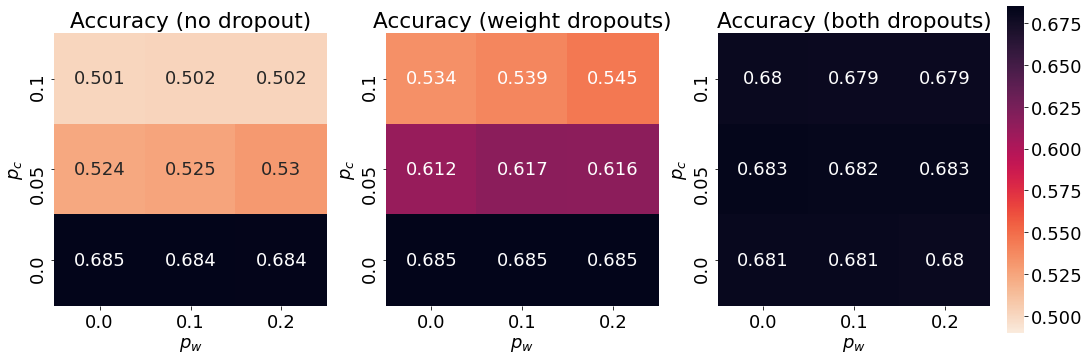

In [49]:
heatmap_plot('acc')

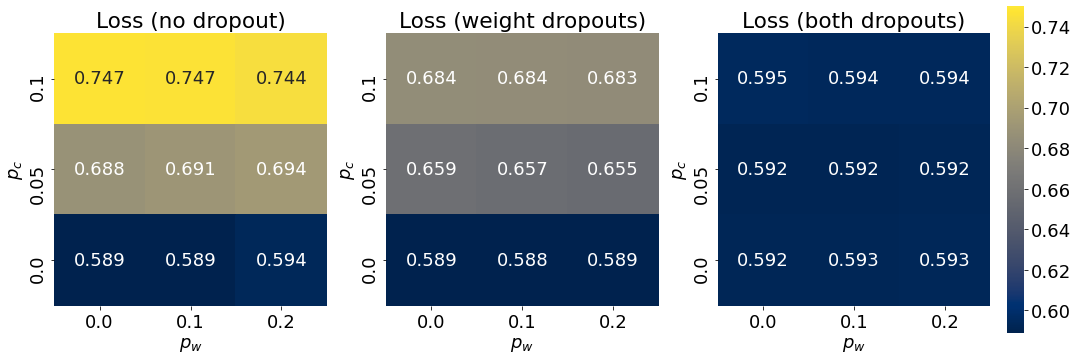

In [50]:
heatmap_plot('log_loss')

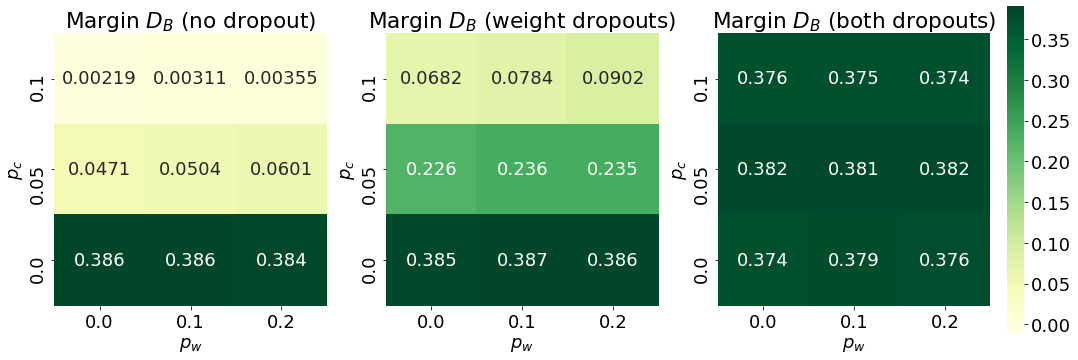

In [51]:
heatmap_plot('d_m')

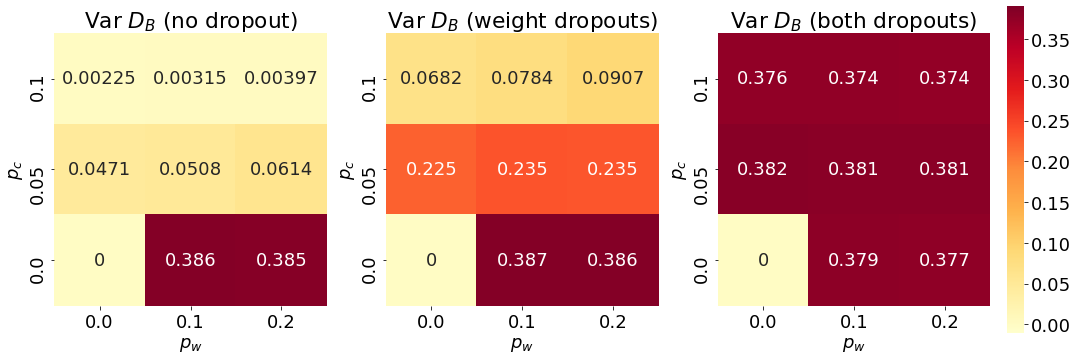

In [52]:
heatmap_plot('d_tvar')

## 2.2 - Uncertainty assassement

In [38]:
#[total_variance, entropy, mutual_info, margin_confidence, variation_ratio]

folder = '21'

uncertainties = np.load(base_path+folder+'/outputs/uncertainties.npy')

predictions = np.expand_dims(np.load(base_path+folder+'/outputs/predictions.npy'), axis=1)
probs = np.expand_dims(np.load(base_path+folder+'/outputs/softmax.npy')[:,1], axis=1)

uncertainties = np.concatenate((uncertainties,probs,predictions,np.expand_dims(labels, axis=1)),axis=1)

In [39]:
uncertainties_df = pd.DataFrame(
    uncertainties, columns=['total_variance', 'entropy', 'mutual_info', 'margin_confidence', 'variation_ratio', 'probs', 'pred', 'gt'])

In [40]:
uncertainties_df['pred'] = uncertainties_df['pred'].astype(int)
uncertainties_df['gt'] = uncertainties_df['gt'].astype(int)

# normalize entropy
uncertainties_df['entropy'] = uncertainties_df['entropy']/np.log(2)

uncertainties_df['correct_pred'] = np.where(uncertainties_df['pred'] == uncertainties_df['gt'], 1, 0)

In [41]:
uncertainties_df

,total_variance,entropy,mutual_info,margin_confidence,variation_ratio,probs,pred,gt,correct_pred
0,0.0126,0.9732,0.0003,0.1922,0.0,0.5961,1,0,0
1,0.0326,0.7894,0.0028,0.5267,0.0,0.2366,0,0,1
2,0.0279,0.7861,0.0021,0.5306,0.0,0.7653,1,0,0
3,0.0269,0.8837,0.0017,0.3960,0.0,0.3020,0,0,1
4,0.0118,0.9934,0.0003,0.0958,0.0,0.4521,0,0,1
...,...,...,...,...,...,...,...,...,...
70778,0.0187,0.9302,0.0008,0.3086,0.0,0.3457,0,1,0
70779,0.0284,0.3918,0.0052,0.8459,0.0,0.9229,1,1,1
70780,0.0270,0.8627,0.0017,0.4292,0.0,0.2854,0,1,0
70781,0.0131,0.9841,0.0003,0.1484,0.0,0.5742,1,1,1


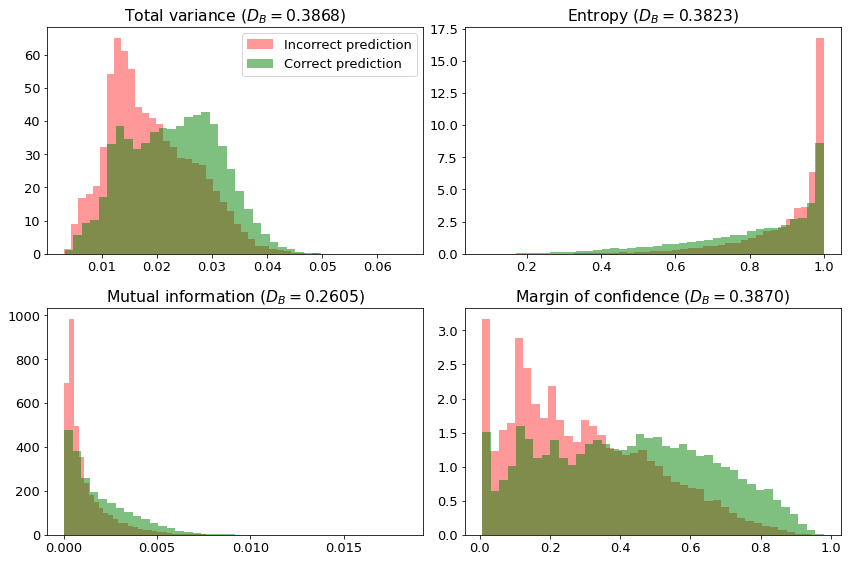

In [43]:
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))


correct = uncertainties_df[uncertainties_df['correct_pred'] == 1]['total_variance']
incorrect = uncertainties_df[uncertainties_df['correct_pred'] == 0]['total_variance']
correct_pmf = correct.value_counts(normalize=True)
incorrect_pmf = incorrect.value_counts(normalize=True)
d = bhattacharyya_d(correct_pmf.reset_index(drop=True).to_dict(),incorrect_pmf.reset_index(drop=True).to_dict())
axes[0,0].hist(incorrect.values, bins=40, alpha=0.4, label='incorrect', color='r', density=1)
axes[0,0].hist(correct.values, bins=40, alpha=0.5, label='correct', color='g', density=1)
axes[0,0].set_title(r'Total variance ($D_B=%1.4f$)' % d)
#axes[0,0].set_xticks(np.arange(0,uncertainties_df['total_variance'].max(),0.04))
axes[0,0].legend(['Incorrect prediction', 'Correct prediction'], loc=1)

correct = uncertainties_df[uncertainties_df['correct_pred'] == 1]['entropy']
incorrect = uncertainties_df[uncertainties_df['correct_pred'] == 0]['entropy']
correct_pmf = correct.value_counts(normalize=True)
incorrect_pmf = incorrect.value_counts(normalize=True)
d = bhattacharyya_d(correct_pmf.reset_index(drop=True).to_dict(),incorrect_pmf.reset_index(drop=True).to_dict())
axes[0,1].hist(incorrect.values, bins=40, alpha=0.4, label='incorrect', color='r', density=1)
axes[0,1].hist(correct.values, bins=40, alpha=0.5, label='correct', color='g', density=1)
axes[0,1].set_title(r'Entropy ($D_B=%1.4f$)' % d)

correct = uncertainties_df[uncertainties_df['correct_pred'] == 1]['margin_confidence']
incorrect = uncertainties_df[uncertainties_df['correct_pred'] == 0]['margin_confidence']
correct_pmf = correct.value_counts(normalize=True)
incorrect_pmf = incorrect.value_counts(normalize=True)
d = bhattacharyya_d(correct_pmf.reset_index(drop=True).to_dict(),incorrect_pmf.reset_index(drop=True).to_dict())
axes[1,1].hist(incorrect.values, bins=40, alpha=0.4, label='incorrect', color='r', density=1)
axes[1,1].hist(correct.values, bins=40, alpha=0.5, label='correct', color='g', density=1)
axes[1,1].set_title(r'Margin of confidence ($D_B=%1.4f$)' % d)

correct = uncertainties_df[uncertainties_df['correct_pred'] == 1]['mutual_info']
incorrect = uncertainties_df[uncertainties_df['correct_pred'] == 0]['mutual_info']
correct_pmf = correct.value_counts(normalize=True)
incorrect_pmf = incorrect.value_counts(normalize=True)
d = bhattacharyya_d(correct_pmf.reset_index(drop=True).to_dict(),incorrect_pmf.reset_index(drop=True).to_dict())
axes[1,0].hist(incorrect.values, bins=40, alpha=0.4, label='incorrect', color='r', density=1)
axes[1,0].hist(correct.values, bins=40, alpha=0.5, label='correct', color='g', density=1)
axes[1,0].set_xticks(np.arange(0,uncertainties_df['mutual_info'].max(),0.005))
axes[1,0].set_title(r'Mutual information ($D_B=%1.4f$)' % d)

fig.tight_layout()
plt.savefig('uncertainties.png', dpi=300, bbox_inches="tight")
plt.show()